In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
"""
Mount your own Google Drive so Colab can access the dataset.
Instructions:
 - The images are stored in a public Google Drive folder.
 - To access the dataset, click this Drive link in your browser:
 - https://drive.google.com/drive/folders/1J8NR0PeM18kHuRsAgHyi4szJt9fPCA1j?usp=sharing
 - In Drive, click "Add shortcut to Drive" (the Drive icon in the toolbar).
 - Place the shortcut in your "My Drive" so Colab can find it.
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Set the base path below to the name of the shortcut you created in your Drive.
Example:
 - If you added the shortcut as "Vehicles" in your My Drive, use:
     img_base_path = "/content/drive/My Drive/Vehicles/"
 - If you changed the folder name, update accordingly.
"""
img_base_path = "/content/drive/My Drive/Vehicles/"

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    img_base_path,
    validation_split=0.2,        # 80% train, 20% validation
    subset="training",
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
#loads all images from main folder and lables them based on sub-folder names

Found 5565 files belonging to 7 classes.
Using 4452 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    img_base_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 5565 files belonging to 7 classes.
Using 1113 files for validation.


In [ ]:
#using some data from val for test set
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
#class labels from folder names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)

Detected classes: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


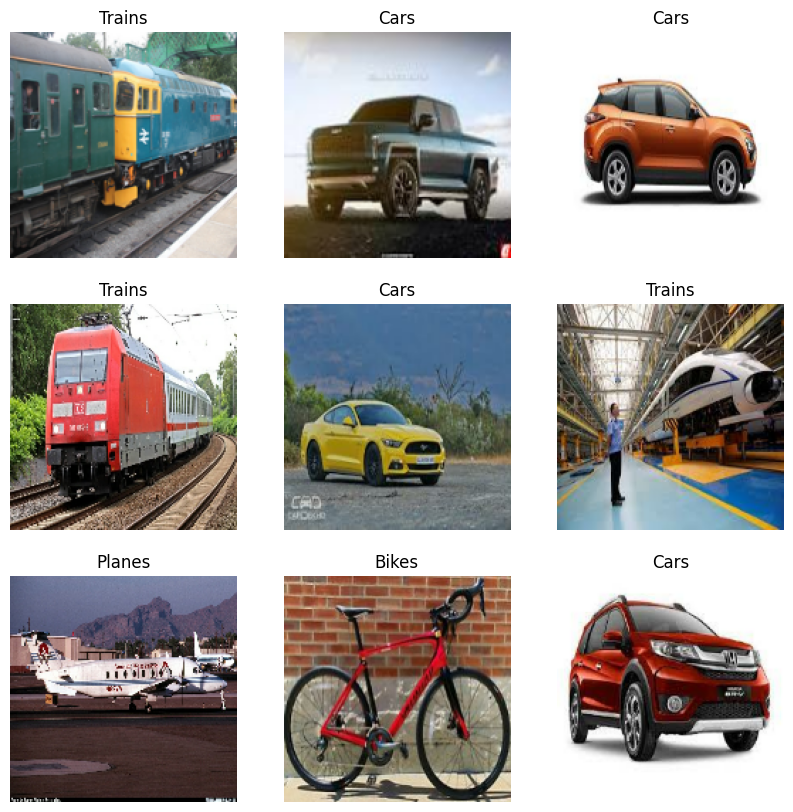

In [ ]:
#visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [ ]:
#buffered prefetching for performance (loads jnext batch in the background for faster training)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print(f'\nNumber of training batches: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation batches: {tf.data.experimental.cardinality(val_ds)}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_ds)}')


Number of training batches: 140
Number of validation batches: 28
Number of test batches: 7


In [ ]:
#data augmentation
#artificially increase the diversity of your training dataset by applying random transformations like flips, rotations, zooms, etc
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
], name='data_augmentation')

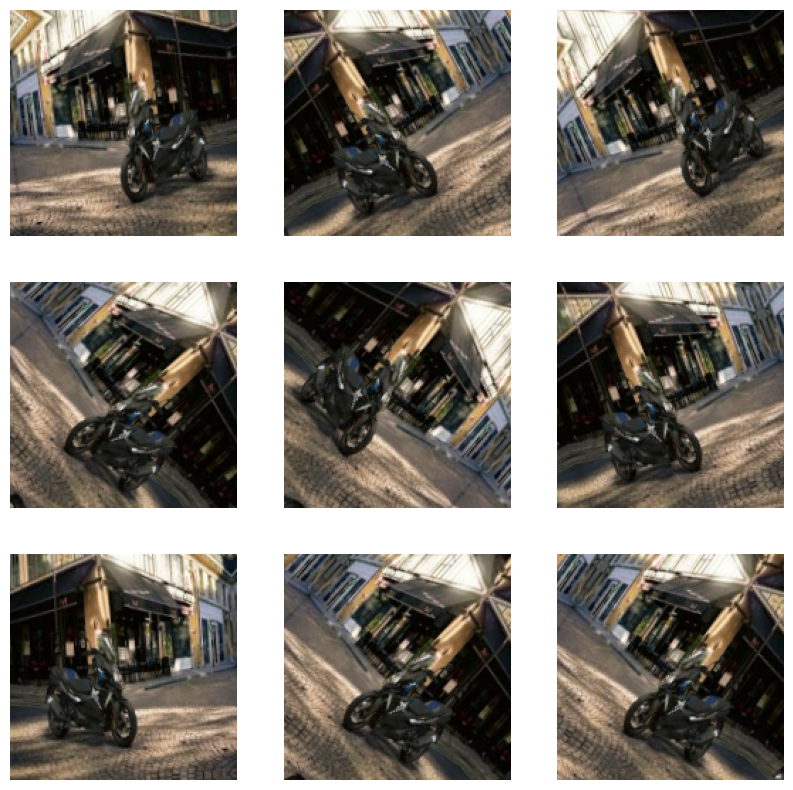

In [ ]:
#visualize augmented images
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    image_x = image[3]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image_x, 0))
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')
    plt.show()

In [ ]:
#preprocessing(applied in the model)
#defines a preprocessing function that prepares input images exactly how MobileNetV2 expects them
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
#experiments log
experiment_log = []

In [ ]:
#Base model
print("\nExperiment 1: base model")

IMG_SHAPE = IMG_SIZE + (3,) #combines image with 3 color channels (RGB)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False, #removes the old Dense layers (add our own)
    weights='imagenet' #loads pretrained weights
)
base_model.trainable = False #freezes pretrained layers (their weights will not update during training)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs) #applies data augmentation pipeline
x = preprocess_input(x) #scales image pixel values as per MobileNetV2
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) #reduces the feature map into a single vector by averaging each feature channel
x = layers.Dropout(0.2)(x) #randomly deactivate 20% neurons during training to reduce overfitting

outputs = layers.Dense(num_classes, activation='softmax')(x)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss_fn,
    metrics=metrics
)

history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=10)

experiment_log.append({
    'Iteration': 1,
    'Parameters': 'Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes',
    'Train_Acc': f"{history_1.history['accuracy'][-1]:.4f}",
    'Val_Acc': f"{history_1.history['val_accuracy'][-1]:.4f}"
})


Experiment 1: base model
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1204s 9s/step - accuracy: 0.2764 - loss: 2.0160 - val_accuracy: 0.8155 - val_loss: 0.8620
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.6602 - loss: 0.9972 - val_accuracy: 0.9303 - val_loss: 0.4759
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 293ms/step - accuracy: 0.7816 - loss: 0.6795 - val_accuracy: 0.9584 - val_loss: 0.3151
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.8390 - loss: 0.5186 - val_accuracy: 0.9618 - val_loss: 0.2392
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.8732 - loss: 0.4152 - val_accuracy: 0.9685 - val_loss: 0.1935
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.8791 - loss: 0.3701 - val_accuracy: 0.9696 - val_loss: 0.1613
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.8910 - loss: 0.3320 - val_accuracy: 0.9708 - val_loss: 0.1481
Epoch 8/1

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 154


In [ ]:
#experiment 2: Higher Dropout, Higher Learning Rate
print("\nExperiment 2: Dropout=0.4, LR=0.0005")
base_model.trainable = False #keeping base model frozen for this experiment

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1a = tf.keras.Model(inputs, outputs)

model_1a.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), #higher LR
    loss=loss_fn,
    metrics=metrics,
)

history_1a = model_1a.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 2,
    'Parameters': 'Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes',
    'Train_Acc': f"{history_1a.history['accuracy'][-1]:.4f}",
    'Val_Acc': f"{history_1a.history['val_accuracy'][-1]:.4f}",
})


Experiment 2: Dropout=0.4, LR=0.0005
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 48s 306ms/step - accuracy: 0.4495 - loss: 1.6367 - val_accuracy: 0.9741 - val_loss: 0.2069
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 292ms/step - accuracy: 0.8474 - loss: 0.4260 - val_accuracy: 0.9831 - val_loss: 0.1068
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.8923 - loss: 0.3077 - val_accuracy: 0.9820 - val_loss: 0.0874
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.9064 - loss: 0.2602 - val_accuracy: 0.9843 - val_loss: 0.0725
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.9273 - loss: 0.2131 - val_accuracy: 0.9854 - val_loss: 0.0636
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.9342 - loss: 0.1957 - val_accuracy: 0.9876 - val_loss: 0.0588
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 292ms/step - accuracy: 0.9399 - loss: 0.1887 - val_accuracy: 0.9854 - val_loss: 0.0569
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 2

In [ ]:
#experiment 3: Fine-tune last 20 layers, Dropout=0.3, Lower Learning Rate
print("\nExperiment 3: Unfreeze last 20 layers, Dropout=0.3, LR=0.00005")

base_model.trainable = True
#unfreezes the last 20 layers of MobileNetV2, so those layers can retrain and adapt to the vehicle dataset
#while all the earlier layers are frozen with their pretrained weights
for layer in base_model.layers[:-20]:
    layer.trainable = False #only last 20 layers trainable

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #lower LR
    loss=loss_fn,
    metrics=metrics,
)

history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 3,
    'Parameters': 'Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes',
    'Train_Acc': f"{history_2.history['accuracy'][-1]:.4f}",
    'Val_Acc': f"{history_2.history['val_accuracy'][-1]:.4f}",
})


Experiment 3: Unfreeze last 20 layers, Dropout=0.3, LR=0.00005
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.5675 - loss: 1.2530 - val_accuracy: 0.9629 - val_loss: 0.1579
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.9099 - loss: 0.2838 - val_accuracy: 0.9798 - val_loss: 0.0891
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.9325 - loss: 0.1959 - val_accuracy: 0.9809 - val_loss: 0.0730
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9469 - loss: 0.1660 - val_accuracy: 0.9831 - val_loss: 0.0566
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 309ms/step - accuracy: 0.9604 - loss: 0.1304 - val_accuracy: 0.9854 - val_loss: 0.0512
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.9588 - loss: 0.1227 - val_accuracy: 0.9876 - val_loss: 0.0464
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9636 - loss: 0.1015 - val_accuracy: 0.9876 - val_loss: 0.0455
Epoch 8/10
140/140 

In [ ]:
print(experiment_log)

[{'Iteration': 1, 'Parameters': 'Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9274', 'Val_Acc': '0.9798'}, {'Iteration': 2, 'Parameters': 'Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9389', 'Val_Acc': '0.9854'}, {'Iteration': 3, 'Parameters': 'Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9728', 'Val_Acc': '0.9843'}]


In [ ]:
#Experiment 4: Unfreeze last 40 layers, Dropout=0.25, LR=0.00001
print("\nExperiment 4: Unfreeze last 40 layers, Dropout=0.25, LR=0.00001")

base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False  #only last 40 layers trainable

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  #lower LR to prevent large gradient updates
    loss=loss_fn,
    metrics=metrics
)

history_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=10)

experiment_log.append({
    'Iteration': 4,
    'Parameters': 'Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes',
    'Train_Acc': f"{history_3.history['accuracy'][-1]:.4f}",
    'Val_Acc': f"{history_3.history['val_accuracy'][-1]:.4f}"
})


Experiment 4: Unfreeze last 40 layers, Dropout=0.25, LR=0.00001
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 305ms/step - accuracy: 0.3299 - loss: 1.8817 - val_accuracy: 0.9044 - val_loss: 0.4803
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.8446 - loss: 0.5671 - val_accuracy: 0.9663 - val_loss: 0.1939
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.9226 - loss: 0.3177 - val_accuracy: 0.9764 - val_loss: 0.1251
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 296ms/step - accuracy: 0.9308 - loss: 0.2481 - val_accuracy: 0.9809 - val_loss: 0.0921
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 294ms/step - accuracy: 0.9403 - loss: 0.2039 - val_accuracy: 0.9820 - val_loss: 0.0794
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 297ms/step - accuracy: 0.9507 - loss: 0.1693 - val_accuracy: 0.9820 - val_loss: 0.0684
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - accuracy: 0.9535 - loss: 0.1723 - val_accuracy: 0.9876 - val_loss: 0.0570
Epoch 8/10
140/140

In [ ]:
#Experiment 5: Unfreeze last 80, Dropout=0.30, LR=5e-6, label_smoothing=0.1
base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
    loss=loss_fn,
    metrics=metrics
)
history_5 = model_5.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({'Iteration':5,'Parameters':'Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1','Train_Acc':f"{history_5.history['accuracy'][-1]:.4f}",'Val_Acc':f"{history_5.history['val_accuracy'][-1]:.4f}"})


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.2184 - loss: 2.1525 - val_accuracy: 0.7582 - val_loss: 0.8200
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 79s 301ms/step - accuracy: 0.6698 - loss: 0.9512 - val_accuracy: 0.9415 - val_loss: 0.3579
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 296ms/step - accuracy: 0.8469 - loss: 0.5487 - val_accuracy: 0.9719 - val_loss: 0.2029
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.8983 - loss: 0.3791 - val_accuracy: 0.9775 - val_loss: 0.1439
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 295ms/step - accuracy: 0.9149 - loss: 0.3162 - val_accuracy: 0.9820 - val_loss: 0.1153
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.9361 - loss: 0.2571 - val_accuracy: 0.9820 - val_loss: 0.0955
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 295ms/step - accuracy: 0.9337 - loss: 0.2264 - val_accuracy: 0.9854 - val_loss: 0.0833
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.9430 - loss: 0

In [ ]:
print(experiment_log)

[{'Iteration': 1, 'Parameters': 'Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9274', 'Val_Acc': '0.9798'}, {'Iteration': 2, 'Parameters': 'Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9389', 'Val_Acc': '0.9854'}, {'Iteration': 3, 'Parameters': 'Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9728', 'Val_Acc': '0.9843'}, {'Iteration': 4, 'Parameters': 'Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9641', 'Val_Acc': '0.9888'}, {'Iteration': 5, 'Parameters': 'Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1', 'Train_Acc': '0.9508', 'Val_Acc': '0.9865'}]


In [ ]:
def set_trainable_tail(model, last_n, freeze_batchnorm=False):
    #Unfreezes only the last `last_n` layers of `model`.
    #Optionally keeps BatchNormalization layers frozen for stability.
    import tensorflow as tf
    model.trainable = True
    cutoff = len(model.layers) - last_n

    for i, layer in enumerate(model.layers):
        #trainable only for last_n layers
        trainable = (i >= cutoff)
        #optionally keep BN frozen
        if freeze_batchnorm and isinstance(layer, tf.keras.layers.BatchNormalization):
            trainable = False
        layer.trainable = trainable


In [ ]:
print("\nExperiment 6: Unfreeze last 80, Freeze BN, Dropout=0.25, LR=0.000010")

set_trainable_tail(base_model, last_n=80, freeze_batchnorm=True)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)      #BN layers won’t update if frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_6 = tf.keras.Model(inputs, outputs)

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000010),
    loss=loss_fn,
    metrics=metrics
)

history_6 = model_6.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 6,
    'Parameters': 'Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010',
    'Train_Acc': f"{history_6.history['accuracy'][-1]:.4f}",
    'Val_Acc':   f"{history_6.history['val_accuracy'][-1]:.4f}"
})



Experiment 6: Unfreeze last 80, Freeze BN, Dropout=0.25, LR=0.000010
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 316ms/step - accuracy: 0.4802 - loss: 1.5766 - val_accuracy: 0.9764 - val_loss: 0.1413
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9311 - loss: 0.2201 - val_accuracy: 0.9809 - val_loss: 0.0754
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - accuracy: 0.9516 - loss: 0.1437 - val_accuracy: 0.9854 - val_loss: 0.0551
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 84s 315ms/step - accuracy: 0.9709 - loss: 0.0905 - val_accuracy: 0.9865 - val_loss: 0.0483
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - accuracy: 0.9633 - loss: 0.0999 - val_accuracy: 0.9843 - val_loss: 0.0442
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 302ms/step - accuracy: 0.9717 - loss: 0.0792 - val_accuracy: 0.9899 - val_loss: 0.0406
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - accuracy: 0.9736 - loss: 0.0832 - val_accuracy: 0.9888 - val_loss: 0.0357
Epoch 8/10
14

In [ ]:
print("\nExperiment 7: AdamW wd=0.000100, L2=0.000100, Unfreeze=50, Dropout=0.25, LR=0.000010")

from tensorflow.keras import regularizers
try:
    OptimW = tf.keras.optimizers.AdamW
except AttributeError:
    OptimW = tf.keras.optimizers.experimental.AdamW

set_trainable_tail(base_model, last_n=50, freeze_batchnorm=False)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(
    num_classes,
    activation='softmax',
    kernel_regularizer=regularizers.l2(0.000100)
)(x)
model_7 = tf.keras.Model(inputs, outputs)

model_7.compile(
    optimizer=OptimW(learning_rate=0.000010, weight_decay=0.000100),
    loss=loss_fn,
    metrics=metrics
)

history_7 = model_7.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 7,
    'Parameters': 'Unfreeze=50, AdamW wd=0.000100, Head L2=0.000100, Dropout=0.25, LR=0.000010',
    'Train_Acc': f"{history_7.history['accuracy'][-1]:.4f}",
    'Val_Acc':   f"{history_7.history['val_accuracy'][-1]:.4f}"
})



Experiment 7: AdamW wd=0.000100, L2=0.000100, Unfreeze=50, Dropout=0.25, LR=0.000010
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 56s 317ms/step - accuracy: 0.2999 - loss: 2.0547 - val_accuracy: 0.9404 - val_loss: 0.2868
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 305ms/step - accuracy: 0.8734 - loss: 0.4891 - val_accuracy: 0.9820 - val_loss: 0.1014
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.9316 - loss: 0.2737 - val_accuracy: 0.9843 - val_loss: 0.0734
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 305ms/step - accuracy: 0.9408 - loss: 0.2145 - val_accuracy: 0.9843 - val_loss: 0.0618
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 308ms/step - accuracy: 0.9562 - loss: 0.1633 - val_accuracy: 0.9865 - val_loss: 0.0555
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.9562 - loss: 0.1463 - val_accuracy: 0.9865 - val_loss: 0.0499
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 309ms/step - accuracy: 0.9674 - loss: 0.1179 - val_accuracy: 0.9854 - val_loss: 0.04

In [ ]:
print("\nExperiment 8: Bottleneck Dense=128, Unfreeze=40, Dropout=0.30+0.20, LR=0.000010")

set_trainable_tail(base_model, last_n=40, freeze_batchnorm=False)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.20)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_8 = tf.keras.Model(inputs, outputs)

model_8.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000010),
    loss=loss_fn,
    metrics=metrics
)

history_8 = model_8.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 8,
    'Parameters': 'Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0.000010',
    'Train_Acc': f"{history_8.history['accuracy'][-1]:.4f}",
    'Val_Acc':   f"{history_8.history['val_accuracy'][-1]:.4f}"
})



Experiment 8: Bottleneck Dense=128, Unfreeze=40, Dropout=0.30+0.20, LR=0.000010
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 319ms/step - accuracy: 0.3316 - loss: 1.9038 - val_accuracy: 0.9629 - val_loss: 0.3157
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.8795 - loss: 0.4943 - val_accuracy: 0.9843 - val_loss: 0.1186
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 302ms/step - accuracy: 0.9374 - loss: 0.2755 - val_accuracy: 0.9865 - val_loss: 0.0736
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 323ms/step - accuracy: 0.9609 - loss: 0.1740 - val_accuracy: 0.9865 - val_loss: 0.0599
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.9627 - loss: 0.1500 - val_accuracy: 0.9876 - val_loss: 0.0532
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9644 - loss: 0.1288 - val_accuracy: 0.9865 - val_loss: 0.0509
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9640 - loss: 0.1291 - val_accuracy: 0.9899 - val_loss: 0.0423
Ep

In [ ]:
print("\nExperiment 9: SGD + CosineDecayRestarts, Unfreeze=80, Dropout=0.25, LR init=0.000010")

set_trainable_tail(base_model, last_n=80, freeze_batchnorm=False)

steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.000010,
    first_decay_steps=steps_per_epoch * 4,
    t_mul=2.0,
    m_mul=0.80,
    alpha=0.000001
)

opt = tf.keras.optimizers.SGD(learning_rate=lr_sched, momentum=0.9, nesterov=True)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_9 = tf.keras.Model(inputs, outputs)

model_9.compile(optimizer=opt, loss=loss_fn, metrics=metrics)

history_9 = model_9.fit(train_ds, validation_data=val_ds, epochs=10)
experiment_log.append({
    'Iteration': 9,
    'Parameters': 'SGD+CosineDecayRestarts, Unfreeze=80, Dropout=0.25, LR_init=0.000010',
    'Train_Acc': f"{history_9.history['accuracy'][-1]:.4f}",
    'Val_Acc':   f"{history_9.history['val_accuracy'][-1]:.4f}"
})



Experiment 9: SGD + CosineDecayRestarts, Unfreeze=80, Dropout=0.25, LR init=0.000010
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 319ms/step - accuracy: 0.2884 - loss: 2.0254 - val_accuracy: 0.6727 - val_loss: 1.0384
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 308ms/step - accuracy: 0.5851 - loss: 1.1639 - val_accuracy: 0.9066 - val_loss: 0.6209
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 304ms/step - accuracy: 0.7478 - loss: 0.8379 - val_accuracy: 0.9415 - val_loss: 0.5107
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - accuracy: 0.7991 - loss: 0.7559 - val_accuracy: 0.9381 - val_loss: 0.4980
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 310ms/step - accuracy: 0.8189 - loss: 0.7087 - val_accuracy: 0.9606 - val_loss: 0.3498
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 308ms/step - accuracy: 0.8688 - loss: 0.5509 - val_accuracy: 0.9719 - val_loss: 0.2719
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 83s 314ms/step - accuracy: 0.8990 - loss: 0.4681 - val_accuracy: 0.9719 - val_loss: 0.24

In [ ]:
print(experiment_log)

[{'Iteration': 1, 'Parameters': 'Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9274', 'Val_Acc': '0.9798'}, {'Iteration': 2, 'Parameters': 'Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9389', 'Val_Acc': '0.9854'}, {'Iteration': 3, 'Parameters': 'Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9728', 'Val_Acc': '0.9843'}, {'Iteration': 4, 'Parameters': 'Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9641', 'Val_Acc': '0.9888'}, {'Iteration': 5, 'Parameters': 'Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1', 'Train_Acc': '0.9508', 'Val_Acc': '0.9865'}, {'Iteration': 6, 'Parameters': 'Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010', 'Train_Acc': '0.9829', 'Val_Acc': '0.9854'}, {'Iteration': 7, 'Parameters': 'Unfreeze=50, AdamW wd=0.000100, Head L2=0.000100, Dropout=0.25, LR=0.000010', 'Train_Acc': '0.9663', 'Val_Acc': '0.9899'}, {'Iteration': 8, 'Parameters': 'Unfreeze=4

In [ ]:
print("\nExperiment 10: Unfreeze=60, Freeze BN, Head: Dense256+BN+Dropout, RMSprop LR=0.000015, ClipNorm=1.0")

#unfreeze only the tail; keep BatchNorm layers frozen for stability
set_trainable_tail(base_model, last_n=60, freeze_batchnorm=True)

#build head with a 256-neuron bottleneck, BN, and dropout
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)   #BN layers stay frozen due to trainable=False
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.30)(x)        #regularize features from backbone
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)  #stabilize the new dense activations
x = layers.Dropout(0.20)(x)        #regularize classifier head
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_10 = tf.keras.Model(inputs, outputs)

#optimizer: RMSprop (good for MobileNet/efficient-style backbones), with gradient clipping
opt_10 = tf.keras.optimizers.RMSprop(
    learning_rate=0.000015,
    rho=0.9,
    momentum=0.0,
    centered=False,
    clipnorm=1.0
)

model_10.compile(
    optimizer=opt_10,
    loss=loss_fn,
    metrics=metrics
)

history_10 = model_10.fit(train_ds, validation_data=val_ds, epochs=10)

experiment_log.append({
    'Iteration': 10,
    'Parameters': 'Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+BN+DO=0.20, RMSprop LR=0.000015, ClipNorm=1.0',
    'Train_Acc': f"{history_10.history['accuracy'][-1]:.4f}",
    'Val_Acc':   f"{history_10.history['val_accuracy'][-1]:.4f}"
})



Experiment 10: Unfreeze=60, Freeze BN, Head: Dense256+BN+Dropout, RMSprop LR=0.000015, ClipNorm=1.0
Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 316ms/step - accuracy: 0.6952 - loss: 0.9189 - val_accuracy: 0.9831 - val_loss: 0.0608
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 308ms/step - accuracy: 0.9721 - loss: 0.1026 - val_accuracy: 0.9809 - val_loss: 0.0509
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - accuracy: 0.9789 - loss: 0.0694 - val_accuracy: 0.9831 - val_loss: 0.0580
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - accuracy: 0.9813 - loss: 0.0548 - val_accuracy: 0.9843 - val_loss: 0.0437
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - accuracy: 0.9828 - loss: 0.0508 - val_accuracy: 0.9899 - val_loss: 0.0352
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - accuracy: 0.9879 - loss: 0.0421 - val_accuracy: 0.9854 - val_loss: 0.0489
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - accuracy: 0.9898 - loss: 0.0378 - val_accuracy: 0.9876 -

In [ ]:
print(experiment_log)

[{'Iteration': 1, 'Parameters': 'Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9274', 'Val_Acc': '0.9798'}, {'Iteration': 2, 'Parameters': 'Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9389', 'Val_Acc': '0.9854'}, {'Iteration': 3, 'Parameters': 'Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9728', 'Val_Acc': '0.9843'}, {'Iteration': 4, 'Parameters': 'Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes', 'Train_Acc': '0.9641', 'Val_Acc': '0.9888'}, {'Iteration': 5, 'Parameters': 'Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1', 'Train_Acc': '0.9508', 'Val_Acc': '0.9865'}, {'Iteration': 6, 'Parameters': 'Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010', 'Train_Acc': '0.9829', 'Val_Acc': '0.9854'}, {'Iteration': 7, 'Parameters': 'Unfreeze=50, AdamW wd=0.000100, Head L2=0.000100, Dropout=0.25, LR=0.000010', 'Train_Acc': '0.9663', 'Val_Acc': '0.9899'}, {'Iteration': 8, 'Parameters': 'Unfreeze=4

In [ ]:
import pandas as pd

df = pd.DataFrame(experiment_log)
df.to_csv('experiment_log.csv', index=False)


In [ ]:
df.head(10)

,Iteration,Parameters,Train_Acc,Val_Acc
0,1,"Dropout=0.2, LR=0.0001, Dense=None, Augmentati...",0.9274,0.9798
1,2,"Dropout=0.4, LR=0.0005, Dense=None, Augmentati...",0.9389,0.9854
2,3,"Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=No...",0.9728,0.9843
3,4,"Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=N...",0.9641,0.9888
4,5,"Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1",0.9508,0.9865
5,6,"Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010",0.9829,0.9854
6,7,"Unfreeze=50, AdamW wd=0.000100, Head L2=0.0001...",0.9663,0.9899
7,8,"Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0...",0.9704,0.9921
8,9,"SGD+CosineDecayRestarts, Unfreeze=80, Dropout=...",0.9135,0.9809
9,10,"Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+B...",0.9903,0.9910


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, exp_name):
    plt.figure(figsize=(10,4))

    #Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{exp_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{exp_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


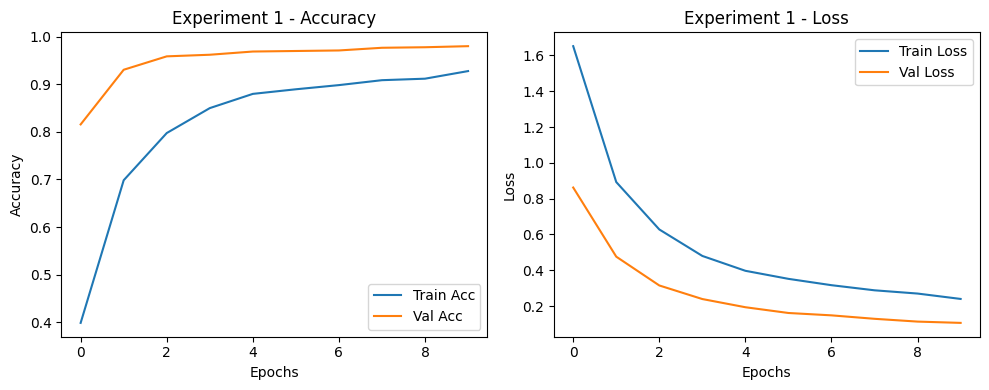

Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes


In [ ]:
plot_history(history_1, "Experiment 1")
print(df['Parameters'][0])

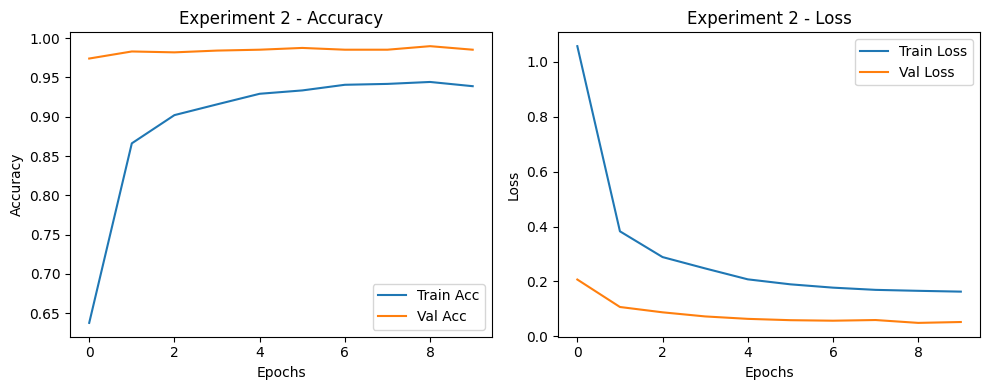

Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes


In [ ]:
plot_history(history_1a, "Experiment 2")
print(df['Parameters'][1])

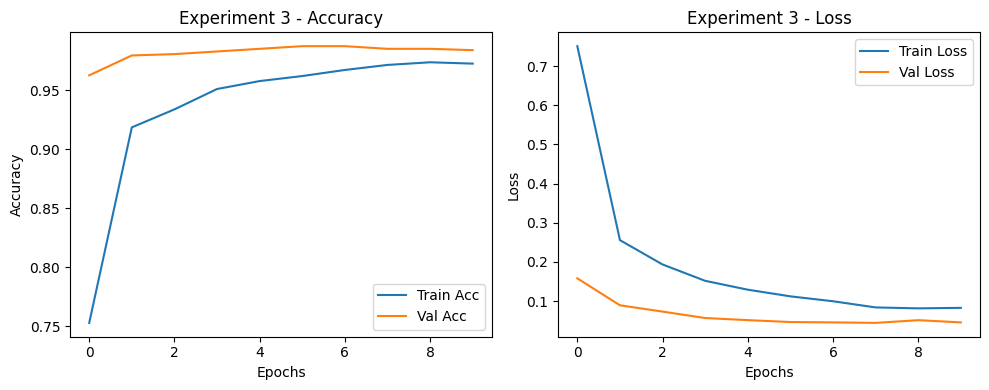

Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes


In [ ]:
plot_history(history_2, "Experiment 3")
print(df['Parameters'][2])

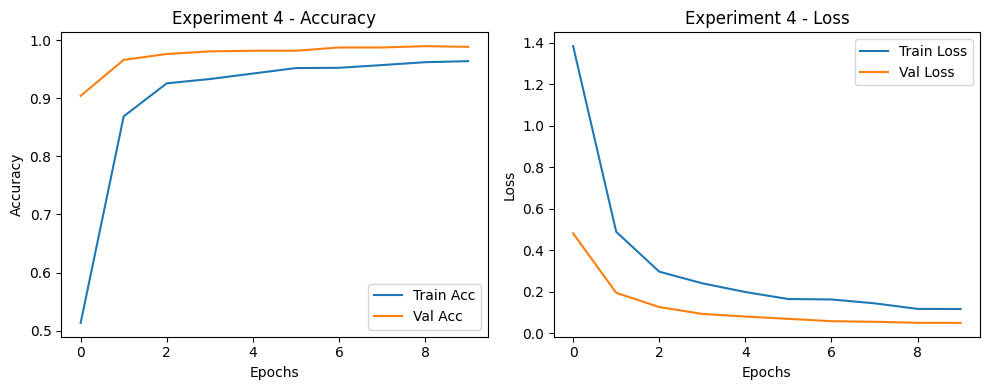

Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes


In [ ]:
plot_history(history_3, "Experiment 4")
print(df['Parameters'][3])

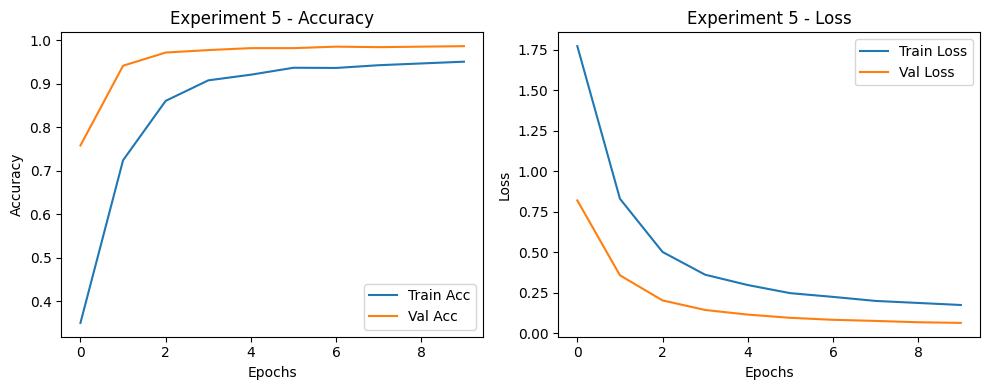

Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1


In [ ]:
plot_history(history_5, "Experiment 5")
print(df['Parameters'][4])

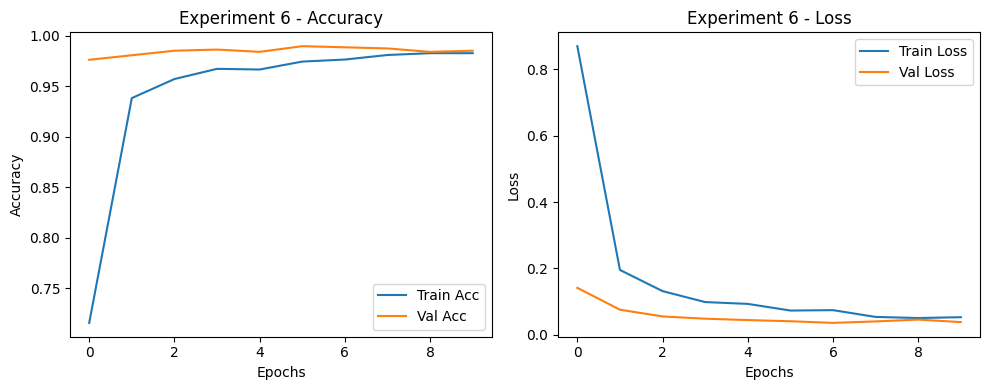

Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010


In [ ]:
plot_history(history_6, "Experiment 6")
print(df['Parameters'][5])

```markdown
## Experiment Summary

Based on the `experiment_log`, here's a summary of the experiments:

| Iteration | Parameters                                                    | Train Accuracy | Validation Accuracy |
|-----------|---------------------------------------------------------------|----------------|---------------------|
| 1         | Dropout=0.2, LR=0.0001, Dense=None, Augmentation=Yes          | 92.74%         | 97.98%              |
| 2         | Dropout=0.4, LR=0.0005, Dense=None, Augmentation=Yes          | 93.89%         | 98.54%              |
| 3         | Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=None, Augmentation=Yes | 97.28%         | 98.43%              |
| 4         | Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=None, Augmentation=Yes | 96.41%         | 98.88%              |
| 5         | Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1                         | 95.08%         | 98.65%              |
| 6         | Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010              | 98.29%         | 98.54%              |
| 7         | Unfreeze=50, AdamW wd=0.000100, Head L2=0.000100, Dropout=0.25, LR=0.000010 | 96.63%         | 98.99%              |
| 8         | Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0.000010         | 97.04%         | **99.21%**          |
| 9         | SGD+CosineDecayRestarts, Unfreeze=80, Dropout=0.25, LR_init=0.000010 | 91.35%         | 98.09%              |
| 10        | Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+BN+DO=0.20, RMSprop LR=0.000015, ClipNorm=1.0 | **99.03%**     | 99.10%              |

**Key Observations:**
*   Experiment 8 (Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0.000010) achieved the highest validation accuracy of **99.21%**, suggesting that fine-tuning the last 40 layers, adding a Dense layer with 128 neurons, and specific dropout rates worked very well.
*   Experiment 10 (Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+BN+DO=0.20, RMSprop LR=0.000015, ClipNorm=1.0) also showed excellent performance with a validation accuracy of 99.10% and the highest training accuracy of 99.03%, demonstrating the effectiveness of RMSprop, freezing Batch Normalization, and a more complex head.
*   Experiments involving unfreezing more layers (e.g., Experiments 3, 4, 6, 7, 8, 10) generally led to higher accuracies compared to the initial base models (Experiments 1 and 2), indicating the benefit of fine-tuning the pre-trained MobileNetV2.
*   Different learning rates and dropout configurations significantly impacted performance, with lower learning rates often proving beneficial when fine-tuning.
*   The SGD optimizer with CosineDecayRestarts (Experiment 9) resulted in a slightly lower training accuracy compared to Adam or RMSprop in other fine-tuning experiments, but still maintained a high validation accuracy.
```

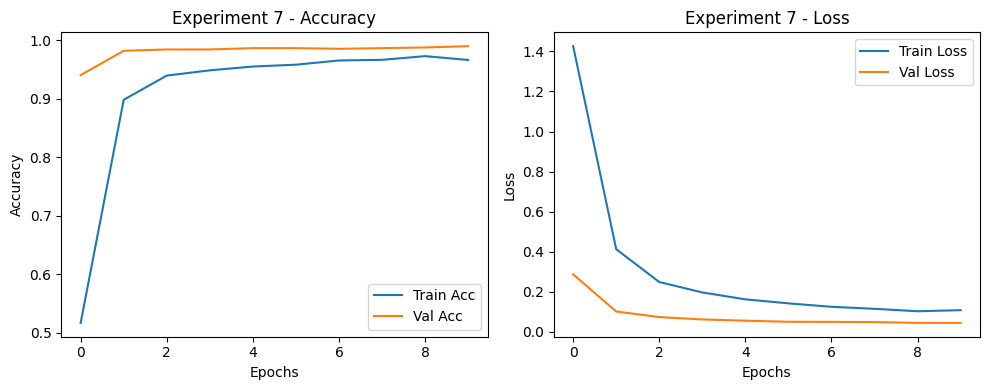

Unfreeze=50, AdamW wd=0.000100, Head L2=0.000100, Dropout=0.25, LR=0.000010


In [ ]:
plot_history(history_7, "Experiment 7")
print(df['Parameters'][6])

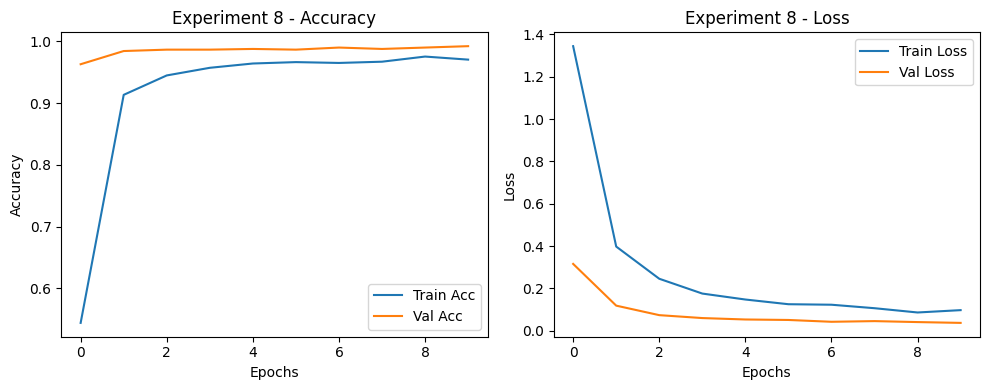

Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0.000010


In [ ]:
plot_history(history_8, "Experiment 8")
print(df['Parameters'][7])

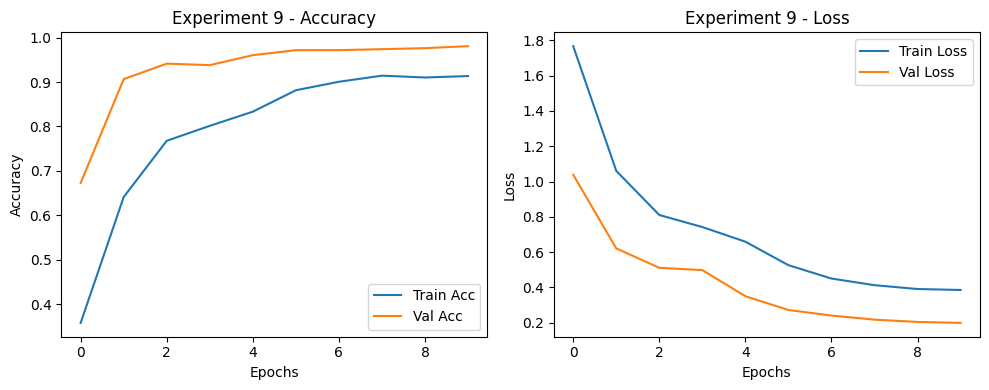

SGD+CosineDecayRestarts, Unfreeze=80, Dropout=0.25, LR_init=0.000010


In [ ]:
plot_history(history_9, "Experiment 9")
print(df['Parameters'][8])

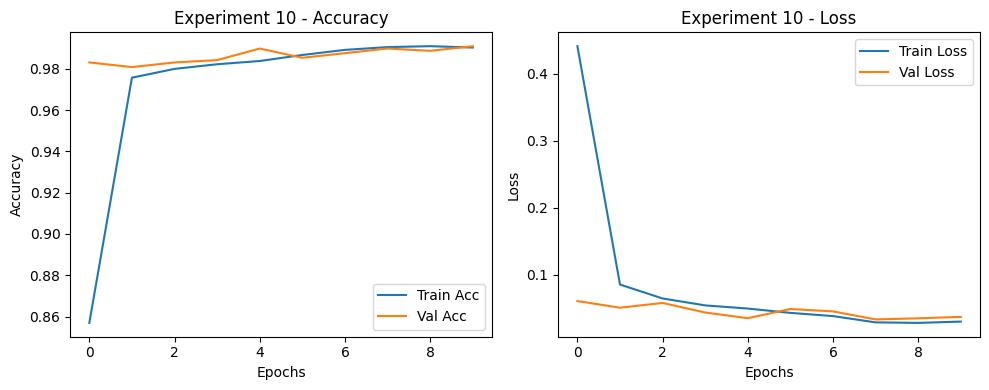

Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+BN+DO=0.20, RMSprop LR=0.000015, ClipNorm=1.0


In [ ]:
plot_history(history_10, "Experiment 10")
print(df['Parameters'][9])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


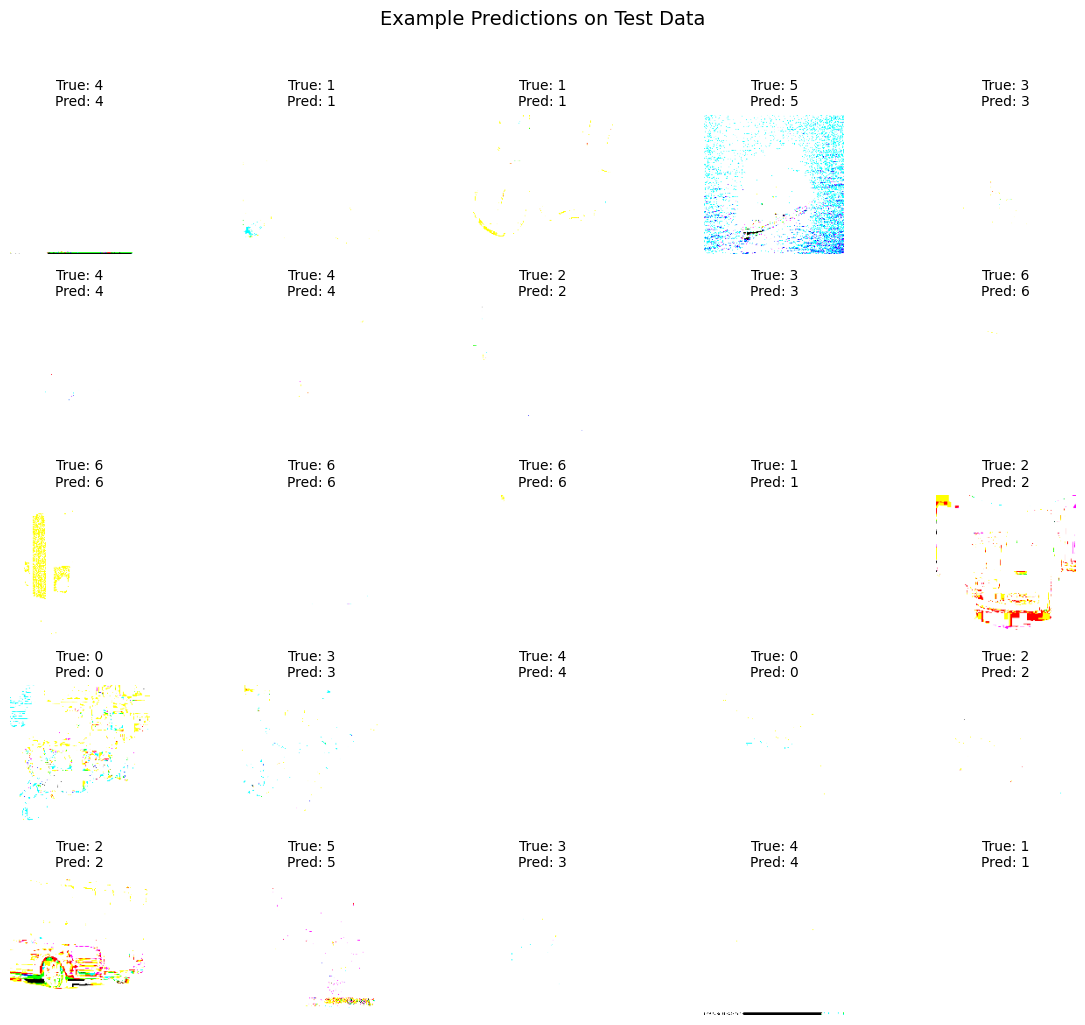

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#pick which model to use
model_to_use = model_10

#25 samples from your test dataset
sample_ds = test_ds.unbatch().take(25)  #unbatch to get individual images

images = []
true_labels = []

for img, label in sample_ds:
    images.append(img)
    true_labels.append(label.numpy())

images = np.array(images)
true_labels = np.array(true_labels)

#predict
pred_probs = model_to_use.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

#plot
plt.figure(figsize=(12, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='viridis')
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Example Predictions on Test Data", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("test_predictions_clean.png", dpi=150, bbox_inches='tight')
plt.show()

#save locally
plt.savefig("test_predictions_25.png", dpi=150, bbox_inches='tight')

#save to Google Drive
from google.colab import drive
drive.mount('/content/drive')
plt.savefig("/content/drive/MyDrive/test_predictions_25.png", dpi=150, bbox_inches='tight')


In [ ]:
"""
MobileNetV2 applies a preprocessing function called - tf.keras.applications.mobilenet_v2.preprocess_input()

This function rescales the image pixel values from the normal range of [0, 255] (original RGB image) to the range [-1, 1]

So inside the model, the image pixel values are centered around 0 (to help training stability).

When we later display these “processed” tensors directly with matplotlip,
it expects pixel values between [0,1] or [0,255], but our preprocessed data is in [-1,1]

So values around -1 (very dark) and 1 (very bright) get clipped weirdly — causing the image to look super pale, low contrast, or completely white.

"""

'\nMobileNetV2 applies a preprocessing function called - tf.keras.applications.mobilenet_v2.preprocess_input()\n\nThis function rescales the image pixel values from the normal range of [0, 255] (original RGB image) to the range [-1, 1]\n\nSo inside the model, the image pixel values are centered around 0 (to help training stability).\n\nWhen we later display these “processed” tensors directly with matplotlip,\nit expects pixel values between [0,1] or [0,255], but our preprocessed data is in [-1,1]\n\nSo values around -1 (very dark) and 1 (very bright) get clipped weirdly — causing the image to look super pale, low contrast, or completely white.\n\n'

In [ ]:
df = pd.DataFrame(experiment_log)

#format training & validation accuracy as percentages
df['Train_Acc'] = (df['Train_Acc'].astype(float) * 100).round(2).astype(str) + '%'
df['Val_Acc']   = (df['Val_Acc'].astype(float) * 100).round(2).astype(str) + '%'

#"Training and Test Accuracy"
df['Training and Test Accuracy'] = 'Train = ' + df['Train_Acc'] + ' and Test = ' + df['Val_Acc']

#required column
table_df = df[['Iteration', 'Parameters', 'Training and Test Accuracy']]

#display
from IPython.display import display
display(table_df)

,Iteration,Parameters,Training and Test Accuracy
0,1,"Dropout=0.2, LR=0.0001, Dense=None, Augmentati...",Train = 92.74% and Test = 97.98%
1,2,"Dropout=0.4, LR=0.0005, Dense=None, Augmentati...",Train = 93.89% and Test = 98.54%
2,3,"Unfreeze=20, Dropout=0.3, LR=0.00005, Dense=No...",Train = 97.28% and Test = 98.43%
3,4,"Unfreeze=40, Dropout=0.25, LR=0.00001, Dense=N...",Train = 96.41% and Test = 98.88%
4,5,"Unfreeze=80, DO=0.30, LR=5e-6, LS=0.1",Train = 95.08% and Test = 98.65%
5,6,"Unfreeze=80, FreezeBN, Dropout=0.25, LR=0.000010",Train = 98.29% and Test = 98.54%
6,7,"Unfreeze=50, AdamW wd=0.000100, Head L2=0.0001...",Train = 96.63% and Test = 98.99%
7,8,"Unfreeze=40, Dense128, Dropout=0.30/0.20, LR=0...",Train = 97.04% and Test = 99.21%
8,9,"SGD+CosineDecayRestarts, Unfreeze=80, Dropout=...",Train = 91.35% and Test = 98.09%
9,10,"Unfreeze=60, FreezeBN, GAP-DO=0.30, Dense256+B...",Train = 99.03% and Test = 99.1%
